# [Project] 용도별 목적대화 데이터를 활용한 화자 의도 분류 프로젝트

---

## 프로젝트 목표
- 다양한 분야의 고객 상담형 대화, 주문 및 예약형 대화 등 고객 문의와 그에 대한 응대를 위한 목적별 대화 등에서 발화자의 화행(발화 의도)을  분류하는 프로젝트 수행

---

## 데이터 출처
-  https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=544

---

## 프로젝트 개요

이번 프로젝트에서는 BiLSTM(양방향 LSTM) 기술을 활용하여 용도별 목적대화 데이터의 화행을 분류하는 프로젝트를 수행합니다.

식음료, 주거와 생활, 교통 등 20여개의 주제에 관한 대화에서 단언하기, 지시하기, 언약하기, 표현하기 등 4개의 화행을 분류합니다.

---

## 1. 데이터 읽기

pandas를 사용하여 `용도별 목적대화 데이터_화행분류full.csv` 데이터를 읽고 dataframe 형태로 저장하고 데이터를 확인합니다.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 엘리스 환경에서 한글 폰트를 사용하기 위한 코드입니다.
font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)

plt.rc('font', family='NanumBarunGothic') 

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf

# 데이터 파일 경로 정의하기
fp = './용도별 목적대화 데이터_화행full.csv'

# csv 파일 읽기
df = pd.read_csv(fp, header=None)
df.columns = ['대화문', '화행']
df.head()

,대화문,화행
0,기다려 주셔서 감사합니다 문의 주신 부분 인터넷 확인해보았습니다,표현
1,제품이 #@모델명# 모델이고요,단언
2,고객님 주문 취소하시면 포인트도 함께 환불이 됩니다,단언
3,십 일 후요 네 해 주세요 수고하세요,표현
4,그렇군요 알겠습니다 다른 질문 사항 생기면 연락 드리겠습니다,언약


먼저 분류해야할 카테고리를 확인합니다. 

In [8]:
# 먼저 화행 종류를 확인
df.화행.unique()

array(['표현', '단언', '언약', '지시'], dtype=object)

화행은 표현, 단언, 언약, 지시로 4가지입니다. 즉, 분류해야할 class가 4개입니다.

그래프를 활용하여 화행 별로 데이터 분포를 확인합니다.

<AxesSubplot:xlabel='화행', ylabel='count'>

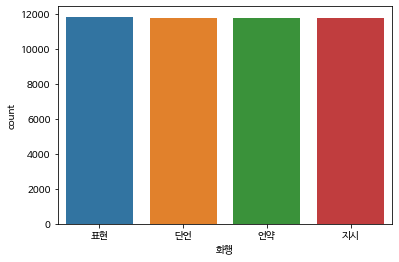

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 카테고리 분포 확인
fig, axe = plt.subplots(ncols=1)
sns.countplot(x = df.화행)

위 그래프를 확인하면, 화행별로 비율을 고르게 분포되어 있습니다.
참고로 데이터를 학습하기 위하여 테스트셋을 분류할 때 비율을 유지해주는 것이 좋습니다.
train_test_split 메서드에서 stratify 옵션으로 비율을 유지할 수 있습니다.


화행 분류를 정답 레이블로 활용하기 위하여 숫자데이터로 치환합니다.

In [10]:
# category 컬럼 데이터 변경
df.화행 = df.화행.replace({'단언': 0, '지시': 1, '언약': 2, '표현': 3})

정답 레이블이 되는 `화행` 데이터를 `target`변수에 저장합니다.

In [11]:
target = df.화행.values

# 데이터의 개수를 확인
print(len(target))

47146


학습할 요약문 데이터 `대화문`을 `data`변수에 저장합니다.

In [12]:
data = df.대화문.values

# 데이터의 개수를 확인
print(len(data))

47146


정답 레이블과 학습데이터가 47,146개로 동일합니다.

---

## 2. 형태소 분석하기

KoNLPy("코엔엘파이"라고 읽습니다)는 한국어 정보처리를 위한 파이썬 패키지입니다.

KoNLPy에는 형태소를 분석하고 품사를 태깅할 수 있는 여러개의 패키지를 제공합니다. 여러가지 품사 태거들의 비교는 https://konlpy.org/ko/latest/morph/ 에서 확인할 수 있습니다.

이번 프로젝트에서는 Okt(Twitter) 클래스를 활용하겠습니다.

Stemming(어간 추출)은 어형이 변형된 단어로부터 접사 등을 제거하고 그 `단어의 어간을 분리`하는 것을 말합니다.[위키백과]

형태소는 두 가지 종류가 있습니다. 각각 어간(stem)과 접사(affix)입니다.

1) 어간(stem)
: 단어의 의미를 담고 있는 단어의 핵심 부분.

2) 접사(affix)
: 단어에 추가적인 의미를 주는 부분.

stemming은 정해진 규칙만 보고 단어의 의미를 구분하기 때문에, 어간 추출 후에 나오는 결과 단어는 `사전에 존재하지 않는 단어`일 수도 있습니다.

In [15]:
# 대화문을 KoNLPy 의 Okt 클래스로 형태소 분석
from konlpy.tag import Okt

# Okt 객체 선언
okt = Okt()

# stemming기반 형태소 분석
# 먼저 대화문 1개만 품사 태깅을 해보겠습니다. nore과 stem 파라미터를 True로 설정하여 정규화와 어간 원형으로 태깅합니다.
pos_results = okt.pos(data[0], norm=True, stem=True)

# 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고 명사, 조사, 동사 등의 형태소를 배열 형태로 만다는 과정입니다.
print(pos_results)

[('기다리다', 'Verb'), ('주다', 'Verb'), ('감사하다', 'Verb'), ('문의', 'Noun'), ('주신', 'Noun'), ('부분', 'Noun'), ('인터넷', 'Noun'), ('확인', 'Noun'), ('해보다', 'Verb')]


In [16]:
#품사를 태깅한 대화문을 확인해봅니다.
data[0]

'기다려 주셔서 감사합니다 문의 주신 부분 인터넷 확인해보았습니다'

위와 같이, `기다려 주셔서 감사합니다 문의 주신 부분 인터넷 확인해보았습니다`라는 문장이 `('기다리다', 'Verb') ...` 등으로 형태소별로 구분되고 품사가 태깅된 것을 확인할 수 있습니다.

그리고 okt.pos 함수를 호출할때 stem 파라미터를 True로 설정했기 때문에 `확인해보았습니다`가 `확인`, `해보다`로 태깅된 것을 확인할 수 있습니다.

`data_tokenized` 변수에 모든 대화문을 형태소 분석하여 저장하겠습니다.

형태소를 분석하는 메서드는 아래와 같습니다.

1. okt.morphs()

- 텍스트를 형태소 단위로 나눈다. 옵션으로는 norm과 stem이 있다 

- norm은 normalize의 약자로 문장을 정규화하는 역할

- stem은 각 단어에서 어간을 추출하는 기능

 

2. okt.nouns()

- 텍스트에서 명사만 뽑아낸다.

 

3. okt.phrases()

- 텍스트에서 어절을 뽑아낸다.

 

4. okt.pos()

- 각 품사를 태깅하는 역할. 

- 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고, 나눠진 각 형태소를 그에 해당하는 품사와 함께 리스트화 하는 것을 의미한다. 

                                                                ※ 출처(https://soyoung-new-challenge.tistory.com/31)

이번 프로젝트에서는 okt.morphs 메서드를 사용하겠습니다.

아래 셀을 실행하면 꽤 오랜시간이 필요합니다.(5분정도 소요) 느긋하게 기다려주세요.

In [ ]:
# 대화문 데이터를 형태소 분석 결과로 저장 
data_tokenized = []

# 학습데이터를 형태소 단위로 사용
for text in data:
    data_tokenized.append(okt.morphs(text))

# 행태소 분석된 결과를 확인
print(data_tokenized[0])

okt.pos 메서드를 호출했을 때와 달리, 형태소만 리스트화 되어 있습니다. 

그리고 stem=True 옵션을 주지 않았기 때문에 입력문 `해보았습니다`가 그대로 유지된 것을 확인할 수 있습니다.

In [ ]:
# 형태소 분석 결과의 개수를 확인. 이전에 확인한 개수와 동일한 것을 확인할 수 있습니다.
print(len(data_tokenized))

각 대화문마다 분리된 형태소가 몇개씩인지 확인해보겠습니다.

`data_tokenized` 변수의 각 배열마다 몇개의 형태소가 들어있는지 히스토그램으로 확인하면 대부분의 대화문이 4~13개의 형태소를 가지고 있다는 것을 확인할 수 있습니다.


평균값은 텍스트 데이터를 전처리할때 패딩 기준으로 사용할 예정입니다.

In [ ]:
print('대화문의 최대 길이 :{}'.format(max(len(l) for l in data_tokenized)))
print('대화문의 평균 길이 :{}'.format(sum(map(len, data_tokenized))/len(data_tokenized)))

plt.hist([len(s) for s in data_tokenized], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

---

## 3. 케라스(Keras)의 텍스트 전처리

### 3-1. 정수 인코딩

형태소 분석된 결과를 학습하기 위해서 Keras를 활용하겠습니다.

Keras는 기본적인 전처리 도구들을 제공하는데, `정수 인코딩`을 위해서 Keras의 토크나이저를 사용하겠습니다.

여기서 `정수 인코딩`이란 컴퓨터가 텍스트보다는 숫자를 더 잘 처리할 수 있기 때문에, 자연어 처리 과정에서 텍스트를 숫자로 바꾸는 기법중에 하나입니다. 그리고 그러한 기법들을 본격적으로 적용시키기 위한 첫 단계로 각 단어를 고유한 정수에 맵핑(mapping)시키는 전처리 작업이 필요할 때가 있습니다.

예를 들어 갖고 있는 텍스트에 단어가 5,000개가 있다면, 5,000개의 단어들 각각에 1번부터 5,000번까지 단어와 맵핑되는 고유한 정수, 다른 표현으로는 인덱스를 부여합니다. 가령, book은 150번, dog는 171번, love는 192번, books는 212번과 같이 숫자가 부여됩니다. 인덱스를 부여하는 방법은 여러 가지가 있을 수 있는데 랜덤으로 부여하기도 하지만, 보통은 전처리 또는 빈도수가 높은 단어들만 사용하기 위해서 단어에 대한 빈도수를 기준으로 정렬한 뒤에 부여합니다. [위키독스]

In [ ]:
# Keras의 텍스트 전처리기를 이용하여 정수 인코딩
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()

# fit_on_texts()안에 형태소 분석된 데이터를 입력으로 넣으면 빈도수를 기준으로 단어 집합을 생성
tokenizer.fit_on_texts(data_tokenized) 

fit_on_texts는 입력한 텍스트로부터 단어 `빈도수가 높은 순`으로 정수 인덱스를 부여합니다.

각 단어에 인덱스가 어떻게 부여되었는지를 보려면, `word_index`를 확인하면 됩니다.

In [ ]:
# 각 단어에 부여된 인덱스 확인
print(tokenizer.word_index)

출력 결과를 보면, '#', '#@'이 제일 높은 빈도수를 갖고 있습니다. AIhub에서 학습데이터를 구축할때 상품명, 개인정보와 같은 민감정보를 `#@상품명#`, `#@이름#` 등으로 비식별화 하였습니다.

실제로 단어의 빈도수를 확인하려면 `word_counts`를 보면 됩니다.

In [ ]:
# 각 단어의 사용 빈도수 확인
print(tokenizer.word_counts)

케라스 토크나이저에서는 숫자를 지정해서 빈도수가 높은 단어를 몇개까지 사용할지를 결정할 수 있습니다.

이번 프로젝트에서는 빈도수 상위 3,000개의 단어를 사용한다고 토크나이저를 재정의하겠습니다.

In [ ]:
# 상위 3000개 단어만 학습에 사용

vocab_size = 3000
tokenizer = Tokenizer(num_words = vocab_size) 
tokenizer.fit_on_texts(data_tokenized)

위에서 사용한 방법과 같이 `print(tokenizer.word_index)`로 정수 인덱스를 확인해보면 똑같이 16,621개의 인덱스가 보입니다. 

실제로 3,000개의 형태소가 적용되는건 `texts_to_sequences`를 사용할 때 적용됩니다.

`print(data_index[0])`의 결과를 보면 정수 인덱스가 3,000을 넘지 않습니다.

In [ ]:
# 대화문 데이터를 인덱스로 변환
data_index = tokenizer.texts_to_sequences(data_tokenized)
print(data_index[0])

### 3-2. 패딩

학습할 데이터(대화문)에 들어있는 단어의 개수는 모두 다릅니다. 

앞서 히스토그램으로 확인해봤을때 각 단어의 평균이 8이기 때문에 형태소의 개수를 8개로 동일하게 패딩하겠습니다.

먼저 `data_index`의 학습할 데이터를 학습데이터 80%, 테스트데이터 20% 비율로 나눠주겠습니다. 그리고 앞서 설명한 바와 같이 각 화행의 비율을 유지하기 위하여 `stratify` 파라미터에 정답 레이블 데이터를 설정해줍니다.

In [ ]:
# class 비율(train:validation)에 유지하기 위해 stratify 옵션을 target으로 지정
X_train, X_test, y_train, y_test = train_test_split(data_index, target, test_size=0.2, stratify=target, random_state=100)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 훈련용 대화문과 테스트용 대화문의 길이, 즉 형태소 개수를 8으로 일치
# 단어수가 8개보다 많으면 나머지는 제거하고 모자르면 0으로 채워짐
max_len = 8

X_train = pad_sequences(X_train, maxlen=max_len) # 훈련용 대화문 패딩
X_test = pad_sequences(X_test, maxlen=max_len) # 테스트용 대화문 패딩

---

## 4. BiLSTM으로 대화문 화행 분류하기

텍스트 분류를 BiLSTM을 통해서 수행하겠습니다.

훈련용 데이터와 테스트용 데이터를 `원-핫 인코딩` 하겠습니다.

`원-핫 인코딩`은 단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식입니다.[위키독스]

이번 실습에서는 화행('단언', '지시', '언약', '표현')의 개수가 4개이므로 벡터의 크기는 4이 됩니다.

In [ ]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# 훈련용, 테스트용 대화문 데이터의 레이블을 원-핫 인코딩

y_train = to_categorical(y_train) # 훈련용 대화문 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 대화문 레이블의 원-핫 인코딩

`Embedding()`은 최소 두 개의 인자를 받습니다. 

첫번째 인자는 단어 집합의 크기, 즉 총 단어의 개수입니다.

두번째 인자는 임베딩 벡터의 출력 차원, 즉 결과로서 나오는 임베딩 벡터의 크기입니다.

결과적으로 아래의 코드는 120차원을 가지는 임베딩 벡터 3,000개를 생성합니다. 

마지막으로 4개의 화행을 분류해야하므로, 출력층에서는 4개의 뉴런을 사용합니다. 활성화 함수로는 소프트맥스를 사용하여 4개의 확률분포를 만듭니다. 

In [ ]:
hidden_units = 128

model = Sequential()
model.add(Embedding(3000, 120))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(4, activation='softmax'))

검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 5회 증가하면 학습을 조기 종료(Early Stopping) 하겠습니다.

ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장하겠습니다.


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

다중 클래스 분류(Multi-Class Classification) 문제이므로 손실 함수로는 categorical_crossentropy를 사용합니다.

categorical_crossentropy는 모델의 예측값과 실제값에 대해서 두 확률 분포 사이의 거리를 최소화하도록 훈련합니다.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

이제 학습을 진행합니다. 

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

마지막으로 검증 데이터에 대한 정확도가 가장 높았을 때 저장된 모델인 `best_model.h5`를 로드하여 성능을 평가합니다.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

## 5. 화행(화자 의도) 분류해보기

학습을 통해 저장한 모델을 로드하고 추론하여 화행을 분류해보겠습니다.

테스트용 데이터에서 아래와 같이 한문장을 임의로 고르고 추론을 해보겠습니다. 화행(정답)은 `단언`입니다.

추론을 위해서는 학습할 때와 같이 데이터 전처리를 해줘야 합니다. 즉, 토큰화 → 정수인코딩 → 패딩을 하고 위에서 로드한 모델을 활용하여 predict 메서드를 호출합니다.

In [ ]:
test_tokenized = okt.morphs('네 그렇긴 한데 교환을 하고 싶어서요') # 토큰화
encoded = tokenizer.texts_to_sequences([test_tokenized]) # 정수 인코딩
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

result = loaded_model.predict(pad_new) # 예측

위에서 화행의 4가지 종류 `단언, 지시, 언약, 표현`을 레이블링하기 위해 각각 `0, 1, 2, 3` 숫자데이터로 치환했었습니다.

result 변수의 결과가 무엇인지 확인해보겠습니다.

In [ ]:
predicted_label = np.argmax(result)

print(predicted_label)

결과가 `0: 단언`으로 잘 예측했습니다.

참고로 정답이 여러개인 다중분류 결과는 아래와 같습니다.

In [ ]:
print(result)

이중에서 가장 높은 확률값을 np.argmax 함수로 구해서 결과로 사용합니다.

---

## 퀴즈


학습한 모델을 바탕으로 화행 의도를 분류하는 추론을 해보겠습니다..

우선, **5. 화행 분류해보기** 파트를 참고해서 아래의 대화문(정답 `표현`)을 분류해보겠습니다.

`네 감사합니다 고객님 좋은 하루 보내세요`

`None`으로 표시된 부분을 고쳐서 코드를 완성하세요.

In [ ]:
test_tokenized = okt.morphs('네 감사합니다 고객님 좋은 하루 보내세요') # 토큰화
encoded = tokenizer.texts_to_sequences([None])
pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

result = loaded_model.predict(pad_new) # 예측

predicted_label = np.argmax(result)

## 제출하기

퀴즈 수행 후, 아래 코드를 실행하면 `df` 데이터프레임이 저장된 `submission.pickle` 파일을 제작하여 채점을 받을 수 있습니다.

**아래 코드를 수정하면 채점이 불가능 합니다.**

In [ ]:
import pickle

df_result = pd.DataFrame([predicted_label], columns=["predicted_label"])

with open('submission.pickle', 'wb') as f:
    pickle.dump(df_result, f)

In [ ]:
# 채점을 수행하기 위하여 로그인
import sys
sys.path.append('vendor')
from elice_challenge import check_score, upload

In [ ]:
# 제출 파일 업로드
await upload()

In [ ]:
# 채점 수행
await check_score()